In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dexplot as dxp

In [2]:
transactions = pd.read_csv("transactions_v2.csv")
members = pd.read_csv('members_v3.csv')
train = pd.read_csv("train_v2.csv")
test = pd.read_csv("sample_submission_v2.csv")
user = pd.read_csv("user_logs_v2.csv")

# EDA + Feature Engineering

In [3]:
train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [4]:
train.shape

(970960, 2)

In [5]:
# checking for any null values in the DataFrame
train.isnull().values.any()

False

In [6]:
# checking for duplicate value in the dataframe
train.duplicated().any()

False

Text(0.5, 1.0, 'Class label distribution')

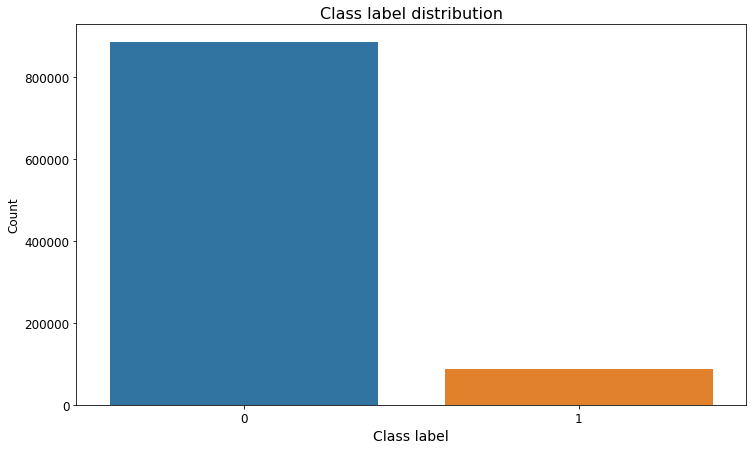

In [7]:
plt.figure(figsize=(12,7))
ax = sns.countplot(data=train, x='is_churn')
plt.xticks(size=12)
plt.xlabel('Class label', size=14)
plt.yticks(size=12)
plt.ylabel('Count', size=12)
plt.title('Class label distribution', size=16)

The training dataset is unbalanced, there are a lot of non-churned useres compared to those who churned. 




# Analysis on Members data

In [8]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [9]:
members.shape

(6769473, 6)

In [10]:
train_members = pd.merge(train, members, on = "msno" , how = "left")
train_members.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [11]:
train_members.shape

(970960, 7)

In [12]:
train_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    860967 non-null  float64
 3   bd                      860967 non-null  float64
 4   gender                  388905 non-null  object 
 5   registered_via          860967 non-null  float64
 6   registration_init_time  860967 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 59.3+ MB


In [13]:
train_members.duplicated("msno").sum()

0

In [14]:
train_members.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time    109993
dtype: int64

### City

In [15]:
train_members['city'].value_counts()

1.0     442598
13.0     97136
5.0      70706
4.0      47227
15.0     43187
22.0     41991
6.0      26066
14.0     20013
12.0     11383
9.0       9526
11.0      9138
18.0      7792
8.0       7589
10.0      6470
17.0      5476
21.0      5199
3.0       5057
7.0       2652
16.0       944
20.0       677
19.0       140
Name: city, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


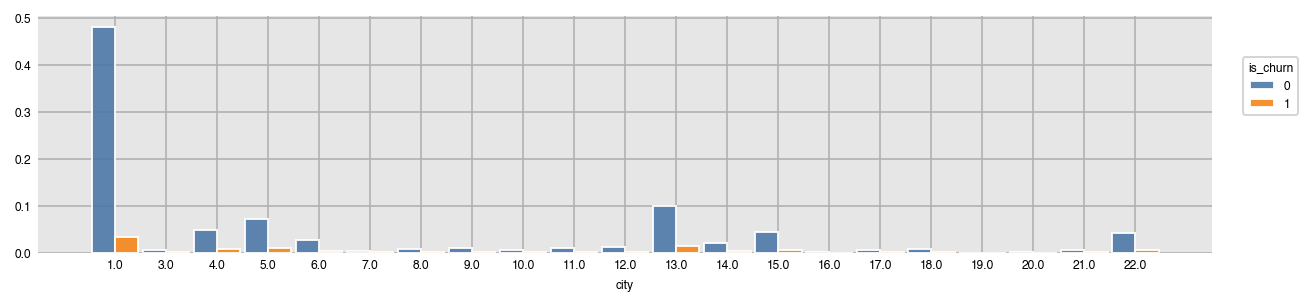

In [16]:
dxp.count('city', data=train_members, split='is_churn', normalize=True)

In [17]:
temp = pd.DataFrame(train_members.groupby("city")["is_churn"].agg(lambda x: x.eq(1).sum())).reset_index()

In [18]:
temp['total_users'] = pd.DataFrame(train_members.groupby("city")["is_churn"].agg(total_users='count')).reset_index()['total_users']

In [19]:
temp['average_churned_users'] = pd.DataFrame(train_members.groupby("city")["is_churn"].agg(average_churned_users='mean')).reset_index()['average_churned_users']

In [20]:
temp.sort_values(by=['total_users'],inplace=True, ascending=False)

In [21]:
temp

,city,is_churn,total_users,average_churned_users
0,1.0,28351,442598,0.064056
11,13.0,11950,97136,0.123023
3,5.0,9333,70706,0.131997
2,4.0,6094,47227,0.129036
13,15.0,5538,43187,0.128233
20,22.0,5284,41991,0.125836
4,6.0,3358,26066,0.128827
12,14.0,2370,20013,0.118423
10,12.0,1585,11383,0.139243
7,9.0,1200,9526,0.125971


In [22]:
train_members.city = train_members.city.fillna(0)

### Birthday

<AxesSubplot:xlabel='is_churn', ylabel='bd'>

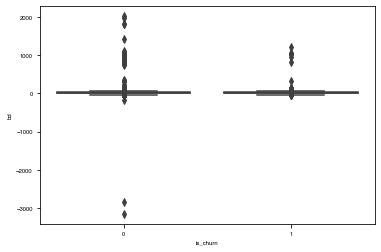

In [23]:
sns.boxplot(x='is_churn', y='bd', data=train_members)

In [24]:
train_members['bd'] = train_members['bd'].apply(lambda x: x if (x < 85.0) and (x > 5.0) else np.nan)

In [25]:
# Delete outliers 
bins = np.arange(1, 10) * 10
train_members['category'] = np.digitize(train_members['bd'], bins, right=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


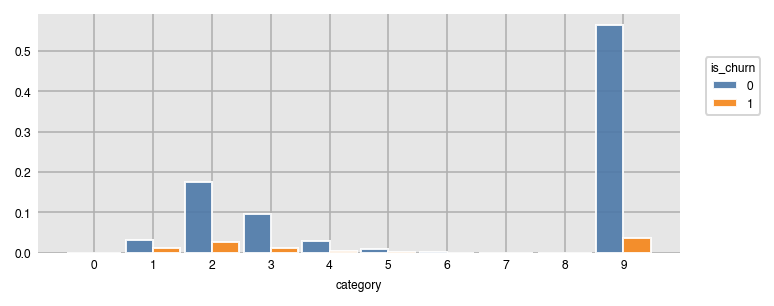

In [26]:
dxp.count('category', data=train_members, split='is_churn', normalize=True)

In [27]:
train_members = train_members.drop('bd', axis = 1)

### Gender 

In [28]:
train_members['gender'].unique()

array(['male', nan, 'female'], dtype=object)

In [29]:
train_members.gender = train_members.gender.map({'male': 1, 'female': 2})
train_members.gender = train_members.gender.fillna(0)

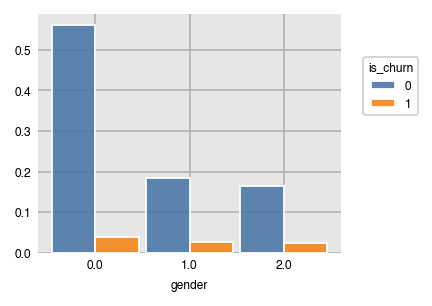

In [30]:
dxp.count('gender', data=train_members, split='is_churn', normalize=True)

### Registred via

In [31]:
train_members['registered_via'].unique()

array([ 3.,  7.,  9., nan,  4., 13.])

In [32]:
train_members.registered_via = train_members.registered_via.fillna(0)

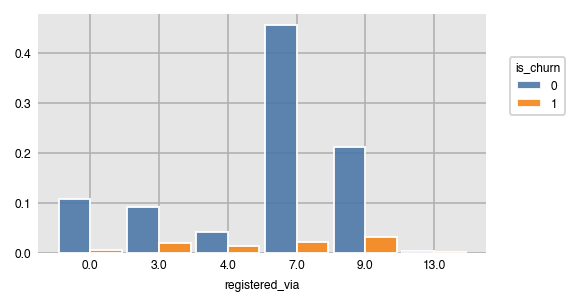

In [33]:
dxp.count('registered_via', data=train_members, split='is_churn', normalize=True)

## registration_init_time

In [34]:
train_members['registration_init_time'] = pd.to_datetime(train_members['registration_init_time'], format='%Y%m%d')

In [35]:
dates = list(train_members.sort_values('registration_init_time')['registration_init_time'])
train_members.registration_init_time = train_members.registration_init_time.fillna(dates[len(dates)//2])

In [36]:
train_members['year'] = train_members['registration_init_time'].dt.year.values
train_members['month'] = train_members['registration_init_time'].dt.month.values
train_members['weekday'] = train_members['registration_init_time'].dt.weekday.values

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


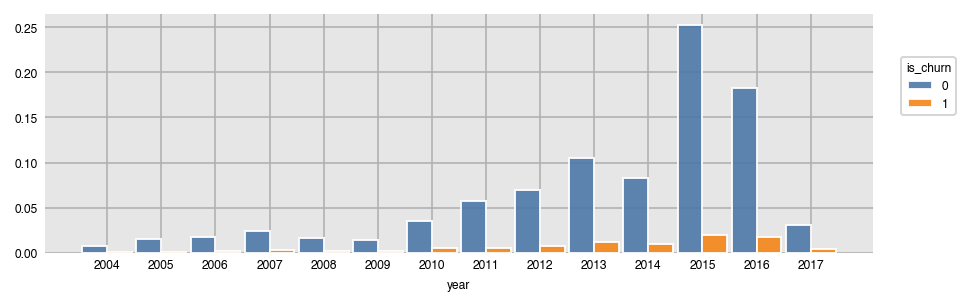

In [37]:
dxp.count('year', data=train_members, split='is_churn', normalize=True)

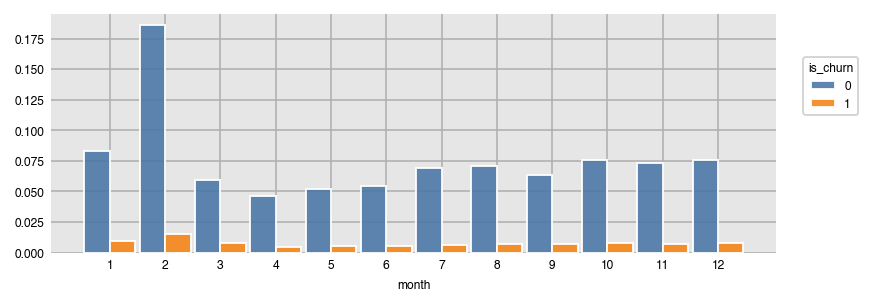

In [38]:
dxp.count('month', data=train_members, split='is_churn', normalize=True)

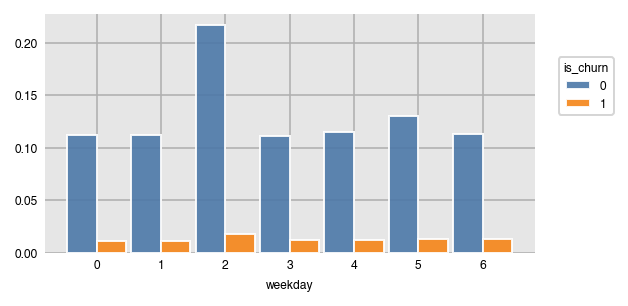

In [39]:
dxp.count('weekday', data=train_members, split='is_churn', normalize=True)

In [40]:
train_members.isnull().sum()

msno                      0
is_churn                  0
city                      0
gender                    0
registered_via            0
registration_init_time    0
category                  0
year                      0
month                     0
weekday                   0
dtype: int64

### All in one 

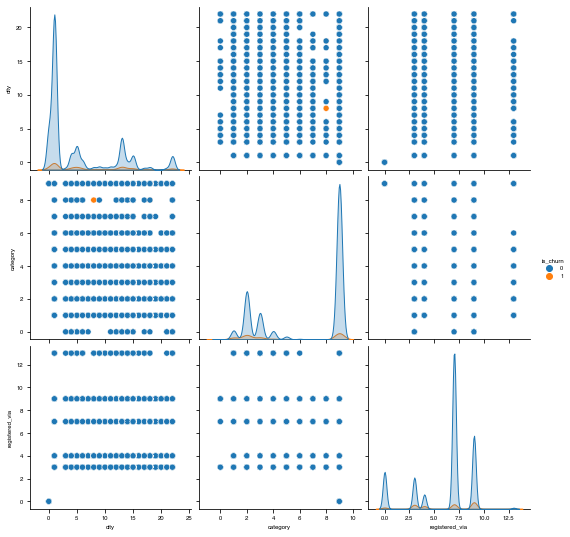

In [41]:
sns.pairplot(train_members, vars=['city', 'category', 'registered_via'], hue='is_churn')

# Transactions

In [42]:
transactions.shape

(1431009, 9)

In [43]:
transactions.duplicated("msno").sum()

233959

In [44]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')

In [45]:
transactions = transactions.sort_values(by=['transaction_date'])
transactions = transactions.drop_duplicates(subset=['msno'], keep='last')

In [46]:
transactions.shape

(1197050, 9)

In [47]:
train_members.shape

(970960, 10)

In [48]:
train_mt = pd.merge(train_members, transactions, on='msno', how='left')

In [49]:
train_mt.shape

(970960, 18)

In [50]:
train_mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    970960 non-null  object        
 1   is_churn                970960 non-null  int64         
 2   city                    970960 non-null  float64       
 3   gender                  970960 non-null  float64       
 4   registered_via          970960 non-null  float64       
 5   registration_init_time  970960 non-null  datetime64[ns]
 6   category                970960 non-null  int64         
 7   year                    970960 non-null  int64         
 8   month                   970960 non-null  int64         
 9   weekday                 970960 non-null  int64         
 10  payment_method_id       933578 non-null  float64       
 11  payment_plan_days       933578 non-null  float64       
 12  plan_list_price         933578

In [51]:
train_mt['payment_method_id'].unique()

array([nan, 36., 15., 41., 40., 38., 32., 39., 37., 35., 20., 30., 29.,
       17., 16., 19., 13., 22., 34., 28., 10., 33., 31., 26., 27., 21.,
       12., 18., 23., 11.,  3., 14.,  6.,  8.])

Text(0.5, 1.0, 'Class label distribution')

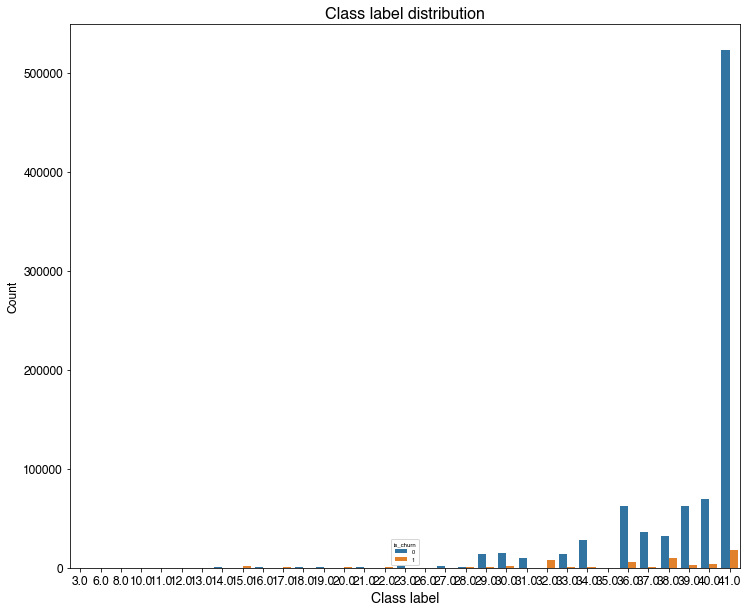

In [52]:
plt.figure(figsize=(12,10))
sns.countplot(data=train_mt, x='payment_method_id',hue='is_churn')
plt.xticks(size=12)
plt.xlabel('Class label', size=14)
plt.yticks(size=12)
plt.ylabel('Count', size=12)
plt.title('Class label distribution', size=16)

In [53]:
train_mt.payment_method_id = train_mt.payment_method_id.fillna(0)

In [54]:
train_mt['payment_plan_days'].unique()

array([ nan,  30.,  90., 410., 180., 195., 360., 240.,   7., 120., 100.,
       365.,  70.,  60.,   1., 200., 400., 395.,  80.,  10., 230., 450.,
        14., 110.,   3., 270., 415.,  35.,   0.])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


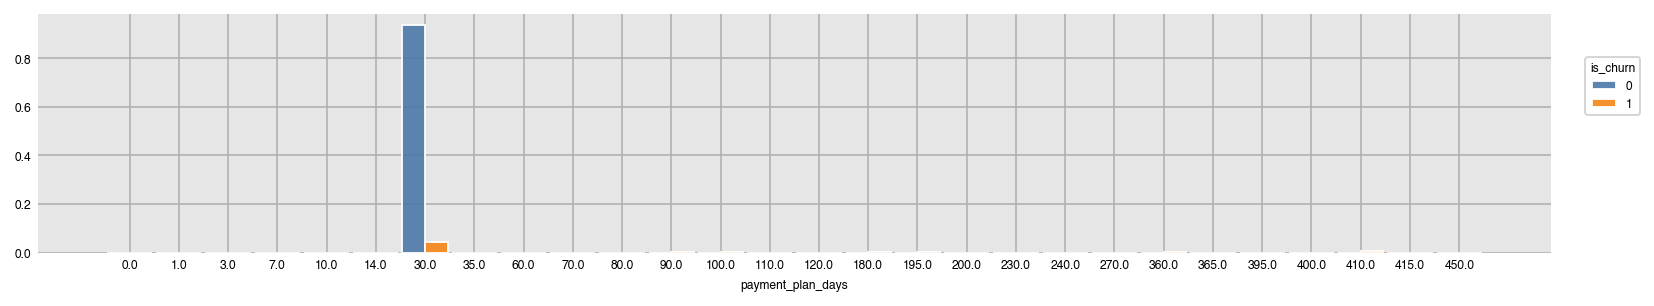

In [55]:
dxp.count('payment_plan_days', data=train_mt, split='is_churn', normalize=True)

<AxesSubplot:xlabel='is_churn', ylabel='payment_plan_days'>

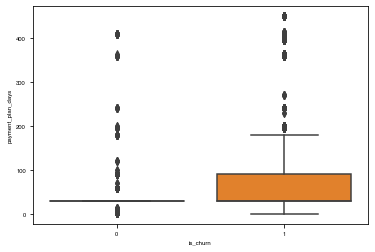

In [56]:
sns.boxplot(x='is_churn', y='payment_plan_days', data=train_mt)

Almost a million of users(94.5%) purchased 30 days subsription, while only fewer and fewer users purchased rest of the plans. And beside 30 days plan, the users who purchased another plan have very high tendency to leave the service.

In [57]:
train_mt['payment_plan_days'] = train_mt['payment_plan_days'].apply(lambda x: x if (x <= 30.0) else np.nan)

In [58]:
train_mt.payment_plan_days = train_mt.payment_plan_days.fillna(np.nanmedian(train_mt['payment_plan_days']))

In [59]:
train_mt.payment_plan_days.unique()

array([30.,  7.,  1., 10., 14.,  3.,  0.])

### Plan list price

In [60]:
train_mt['plan_list_price'].unique()

array([      nan, 1.800e+02, 3.000e+02, 1.490e+02, 9.900e+01, 1.788e+03,
       4.770e+02, 2.980e+02, 5.360e+02, 6.000e+02, 8.940e+02, 1.000e+02,
       1.200e+03, 4.470e+02, 0.000e+00, 4.800e+02, 1.290e+02, 3.500e+02,
       1.299e+03, 9.300e+02, 1.500e+02, 1.599e+03, 7.990e+02, 1.200e+02,
       4.000e+02, 3.500e+01, 1.150e+03, 4.500e+02, 1.190e+02, 1.000e+03,
       5.000e+02, 2.000e+03, 1.000e+00, 1.399e+03, 1.340e+02, 6.990e+02,
       1.260e+02, 2.100e+02, 5.960e+02, 1.310e+02, 2.650e+02, 7.000e+01,
       1.430e+02])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


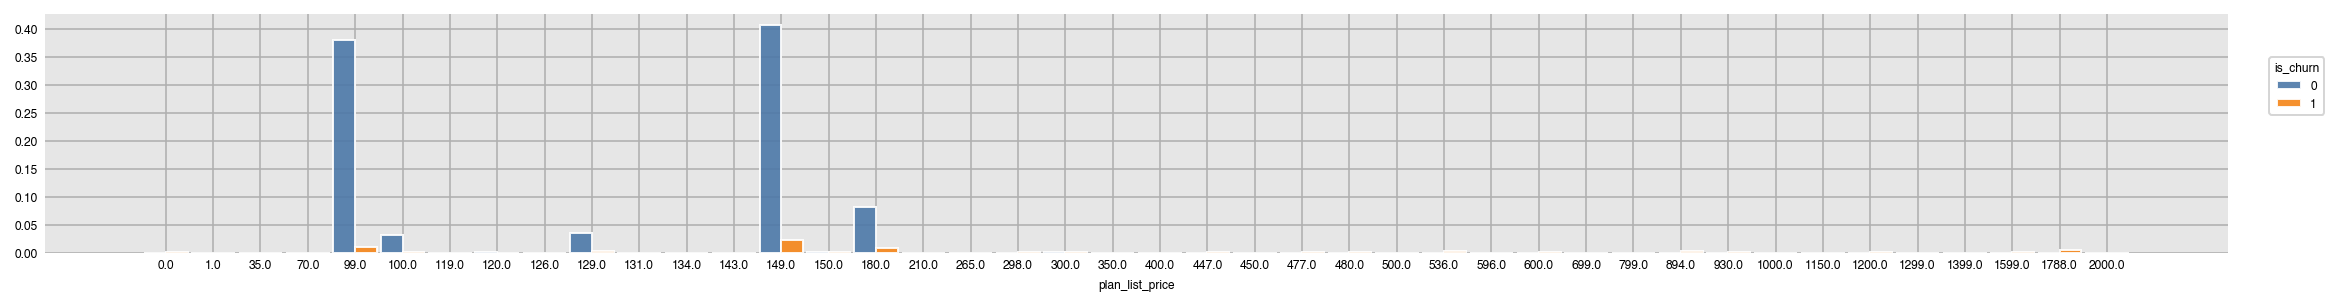

In [61]:
dxp.count('plan_list_price', data=train_mt, split='is_churn', normalize=True)

<AxesSubplot:xlabel='is_churn', ylabel='plan_list_price'>

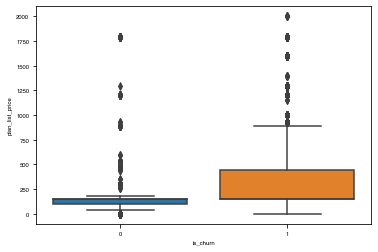

In [62]:
sns.boxplot(x='is_churn', y='plan_list_price', data=train_mt)

In [63]:
# Delete outliers 

In [64]:
mediane = np.nanmedian(train_mt['plan_list_price'])
quantile = train_mt.plan_list_price.quantile(0.95)

In [65]:
train_mt['plan_list_price'] = train_mt['plan_list_price'].apply(lambda x: x if (x <= quantile ) else mediane)

### Actual Amount Paid

In [66]:
train_mt['actual_amount_paid'].unique()

array([      nan, 1.800e+02, 3.000e+02, 1.490e+02, 9.900e+01, 1.788e+03,
       4.770e+02, 2.980e+02, 5.360e+02, 6.000e+02, 8.940e+02, 1.000e+02,
       1.200e+03, 4.470e+02, 0.000e+00, 4.800e+02, 1.290e+02, 3.500e+02,
       1.299e+03, 9.300e+02, 1.500e+02, 1.599e+03, 7.990e+02, 4.000e+02,
       3.500e+01, 1.150e+03, 4.500e+02, 1.190e+02, 1.200e+02, 1.000e+03,
       5.000e+02, 2.000e+03, 1.000e+00, 1.399e+03, 1.340e+02, 6.990e+02,
       1.270e+02, 2.100e+02, 5.960e+02, 1.310e+02, 2.650e+02, 7.000e+01,
       1.430e+02])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


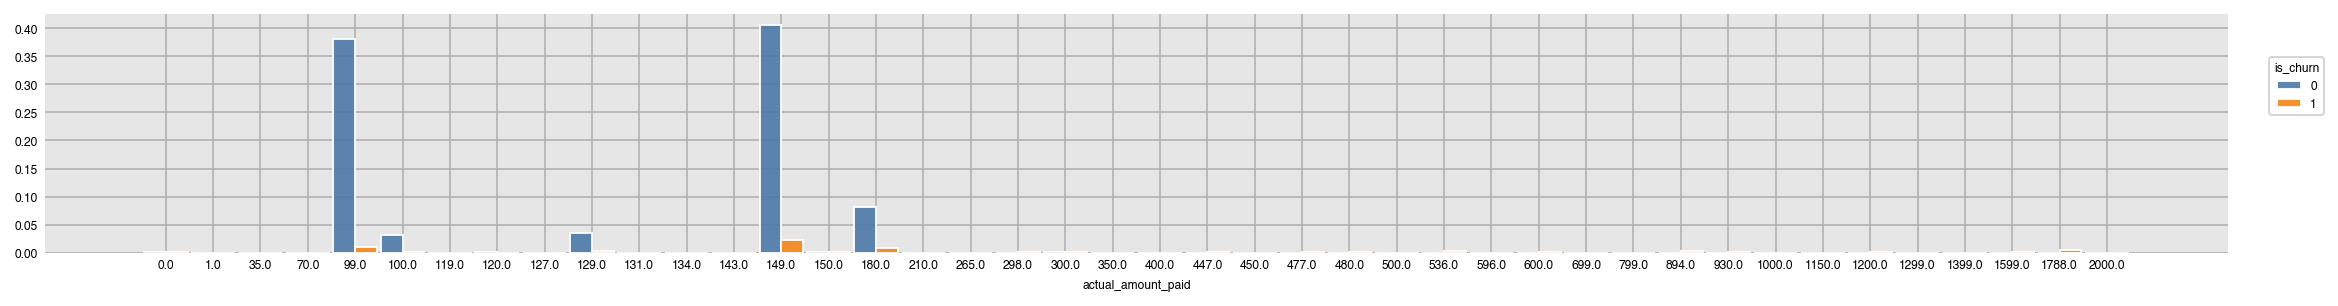

In [67]:
dxp.count('actual_amount_paid', data=train_mt, split='is_churn', normalize=True)

<AxesSubplot:xlabel='is_churn', ylabel='actual_amount_paid'>

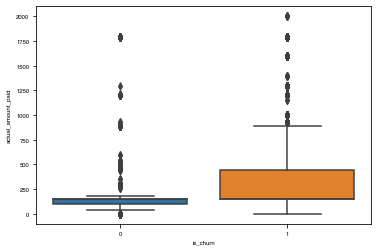

In [68]:
sns.boxplot(x='is_churn', y='actual_amount_paid', data=train_mt)

In [69]:
mediane = np.nanmedian(train_mt['actual_amount_paid'])
quantile = train_mt.actual_amount_paid.quantile(0.95)

In [70]:
train_mt['actual_amount_paid'] = train_mt['actual_amount_paid'].apply(lambda x: x if (x <= quantile) else mediane)

### Is auto renew

In [71]:
train_mt['is_auto_renew'].unique()

array([nan,  0.,  1.])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


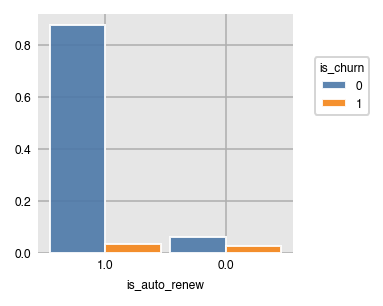

In [72]:
dxp.count('is_auto_renew', data=train_mt, split='is_churn', normalize=True)

In [73]:
# Replace Nan Values 
train_mt.is_auto_renew = train_mt.is_auto_renew.fillna(2)

### Transaction Date

In [74]:
train_mt['year'] = train_mt['transaction_date'].dt.year.values
train_mt['month'] = train_mt['transaction_date'].dt.month.values

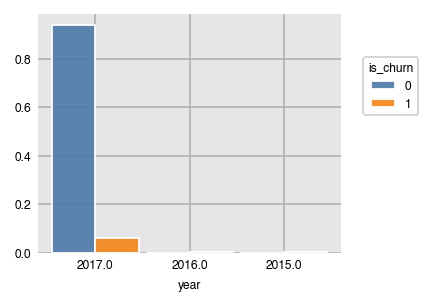

In [75]:
dxp.count('year', data=train_mt, split='is_churn', normalize=True)

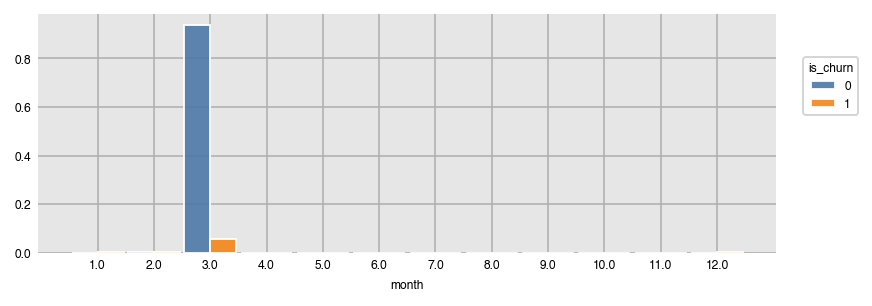

In [76]:
dxp.count('month', data=train_mt, split='is_churn', normalize=True)

In [77]:
dates = list(train_mt.sort_values('transaction_date')['transaction_date'])
train_mt.transaction_date = train_mt.transaction_date.fillna(dates[len(dates)//2])

In [78]:
train_mt['year'] = train_mt['transaction_date'].dt.year.values
train_mt['month'] = train_mt['transaction_date'].dt.month.values

In [79]:
train_mt['membership_expire_date'] = pd.to_datetime(train_mt['membership_expire_date'], format='%Y%m%d')
train_mt['ex_year'] = train_mt['membership_expire_date'].dt.year.values
train_mt['ex_month'] = train_mt['membership_expire_date'].dt.month.values

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


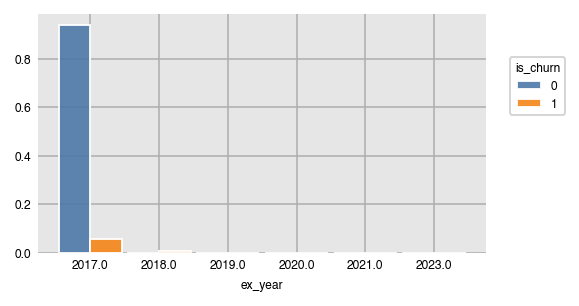

In [80]:
dxp.count('ex_year', data=train_mt, split='is_churn', normalize=True)

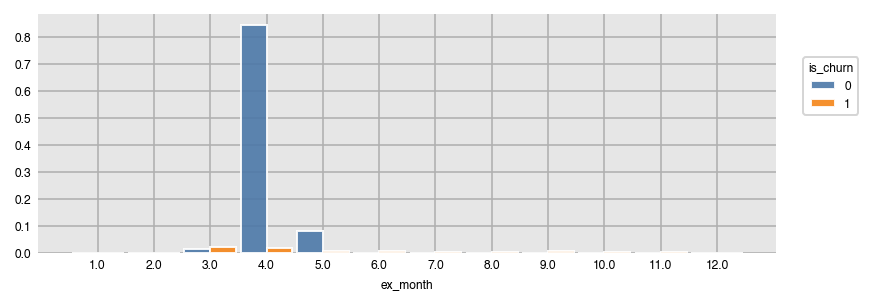

In [81]:
dxp.count('ex_month', data=train_mt, split='is_churn', normalize=True)

In [82]:
dates = list(train_mt.sort_values('membership_expire_date')['membership_expire_date'])
train_mt.membership_expire_date = train_mt.membership_expire_date.fillna(dates[len(dates)//2])

In [83]:
train_mt['ex_year'] = train_mt['membership_expire_date'].dt.year.values
train_mt['ex_month'] = train_mt['membership_expire_date'].dt.month.values

### Is Cancel

In [84]:
train_mt['is_cancel'].unique()

array([nan,  0.,  1.])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


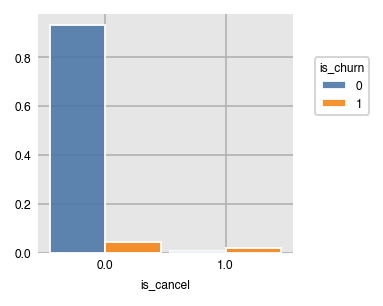

In [85]:
dxp.count('is_cancel', data=train_mt, split='is_churn', normalize=True)

In [86]:
train_mt.is_cancel = train_mt.is_cancel.fillna(2)

In [90]:
sns.pairplot(train_mt, vars=['payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'is_cancel'], hue='is_churn')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa32f3b7310> (for post_execute):


KeyboardInterrupt: 

In [91]:
train_mt.isnull().sum()

msno                      0
is_churn                  0
city                      0
gender                    0
registered_via            0
registration_init_time    0
category                  0
year                      0
month                     0
weekday                   0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
ex_year                   0
ex_month                  0
dtype: int64

In [92]:
user.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [93]:
user.shape

(18396362, 9)

In [94]:
user.duplicated("msno").sum()

17292468

In [95]:
user = user.groupby('msno',as_index=False).mean()
user.drop(columns=['date'],axis=1,inplace=True)
user.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,4534.900962
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,6210.577161
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,4121.830714
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,7137.931333
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,4014.939552


In [96]:
train_mtu = pd.merge(train_mt, user, on='msno', how='left')

In [97]:
train_mtu.shape

(970960, 27)

In [98]:
train_mtu.isnull().sum()

msno                           0
is_churn                       0
city                           0
gender                         0
registered_via                 0
registration_init_time         0
category                       0
year                           0
month                          0
weekday                        0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
ex_year                        0
ex_month                       0
num_25                    216409
num_50                    216409
num_75                    216409
num_985                   216409
num_100                   216409
num_unq                   216409
total_secs                216409
dtype: int64

<AxesSubplot:xlabel='is_churn', ylabel='num_25'>

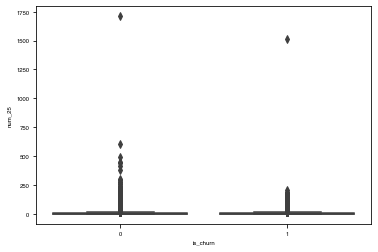

In [99]:
sns.boxplot(x='is_churn', y='num_25', data=train_mtu)

In [103]:
mean_25 = np.nanmedian(train_mtu['num_25'])
mean_50 = np.nanmedian(train_mtu['num_50'])
mean_75 = np.nanmedian(train_mtu['num_75'])
mean_985 = np.nanmedian(train_mtu['num_985'])
mean_100 = np.nanmedian(train_mtu['num_100'])
mean_unq = np.nanmedian(train_mtu['num_unq'])
mean_total = np.nanmedian(train_mtu['total_secs'])

In [104]:
train_mtu.num_25 = train_mtu.num_25.fillna(mean_25)
train_mtu.num_50 = train_mtu.num_25.fillna(mean_50)
train_mtu.num_75 = train_mtu.num_25.fillna(mean_75)
train_mtu.num_985 = train_mtu.num_25.fillna(mean_985)
train_mtu.num_100 = train_mtu.num_25.fillna(mean_100)
train_mtu.num_unq = train_mtu.num_25.fillna(mean_unq)
train_mtu.total_secs = train_mtu.num_25.fillna(mean_total)

In [105]:
train_mtu.isnull().sum()

msno                      0
is_churn                  0
city                      0
gender                    0
registered_via            0
registration_init_time    0
category                  0
year                      0
month                     0
weekday                   0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
ex_year                   0
ex_month                  0
num_25                    0
num_50                    0
num_75                    0
num_985                   0
num_100                   0
num_unq                   0
total_secs                0
dtype: int64

In [107]:
train_mtu.to_csv('final_df.csv', index=False)

In [106]:
sns.pairplot(train_mtu, vars=['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'], hue='is_churn')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa32f3b7310> (for post_execute):


KeyboardInterrupt: 